# Deconvolution with FRC

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [11]:
%matplotlib inline

import os

from supertomo.data.io import carma
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.wrappers import image_writer_wrappers as imwrap



Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [12]:
# Image
data_dir = "/Users/sami/Temp"
filename = "20170120_122128_781.mat"
full_path = os.path.join(data_dir, filename)

data = carma.read_carma_mat(full_path)

print "The Carma file {} contains images from {} laser gates and {} detector channels.".format(
    filename, data.ngates, data.ndetectors)

image = data[0,0]
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

The Carma file 20170120_122128_781.mat contains images from 1 laser gates and 1 detector channels.
The image dimensions are (500, 500) and spacing [0.040080160320641281, 0.040080160320641281] um.


In [13]:
from supertomo.data.containers.image import Image

def get_confocal_psf(ndim, ex_wavelen=633, em_wavelen=660, na=1.4, refr_index=1.51, 
                     pinhole=0.8, magnification=100, sted=False):

    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)

Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


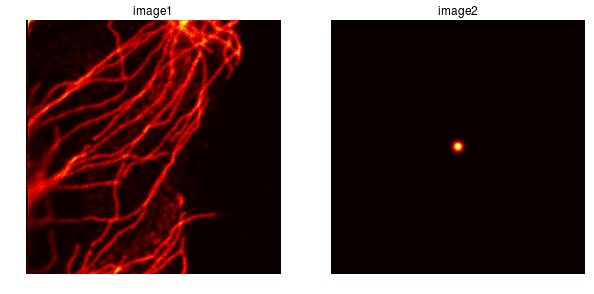

In [14]:
showim.display_2d_images(image, psf)

Run deconvolution

In [15]:
from supertomo.ui import deconvolution_options as options
n_iterations = 20
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=one-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [16]:
writer = imwrap.TiffImageWriter(data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (500, 500)
The deconvolution will be run with 1 blocks
The internal block size is (500, 500)
Preparing image fusion.
Beginning the computation of the 0. estimate
[=>                1/20                ] E/S/U/N=0/977207/1569148/0, LEAK=-1.82873494126e-08%, TAU1=0.077331610024, TIME=0.118s, U/ESU=0.616 
Beginning the computation of the 1. estimate
[===>             2/20                 ] ETA:1.7s E/S/U/N=0/1586953/959402/0, LEAK=4.983813362e-09%, TAU1=0.0467792488635, TIME=8.74E-2s, U/ESU=0.377 
Beginning the computation of the 2. estimate
[=====>           3/20                 ] ETA:1.6s E/S/U/N=0/2039755/506600/0, LEAK=-2.02290406648e-08%, TAU1=0.0338498055935, TIME=8.86E-2s, U/ESU=0.199 
Beginning the computation of the 3. estimate
[=======>         4/20                 ] ETA:1.5s E/S/U/N=0/2267669/278686/0, LEAK=-4.39892566817e-09%, TAU1=0.0265790782869, TIME=9.39E-2s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[=========>       5/20        

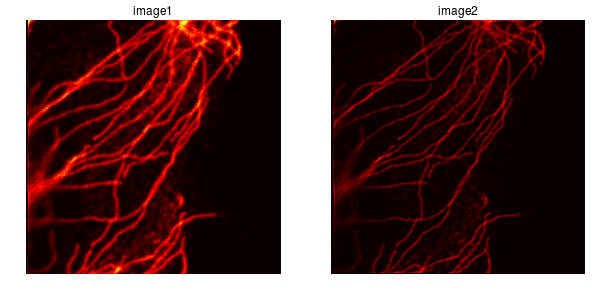

In [17]:
result = task.get_8bit_result()

showim.display_2d_images(image, result)



Show resolution curve

In [18]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image_path = os.path.join(data_dir, image_name)

    image = read.get_image(image_path)
    image1, image2 = imops.summed_checkerboard_split(image)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0]*sqrt(2), args)
results = analyzer.execute()


Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

frc_resolution = dataframe.loc[:, ['duofrc']]

frc_resolution.plot()

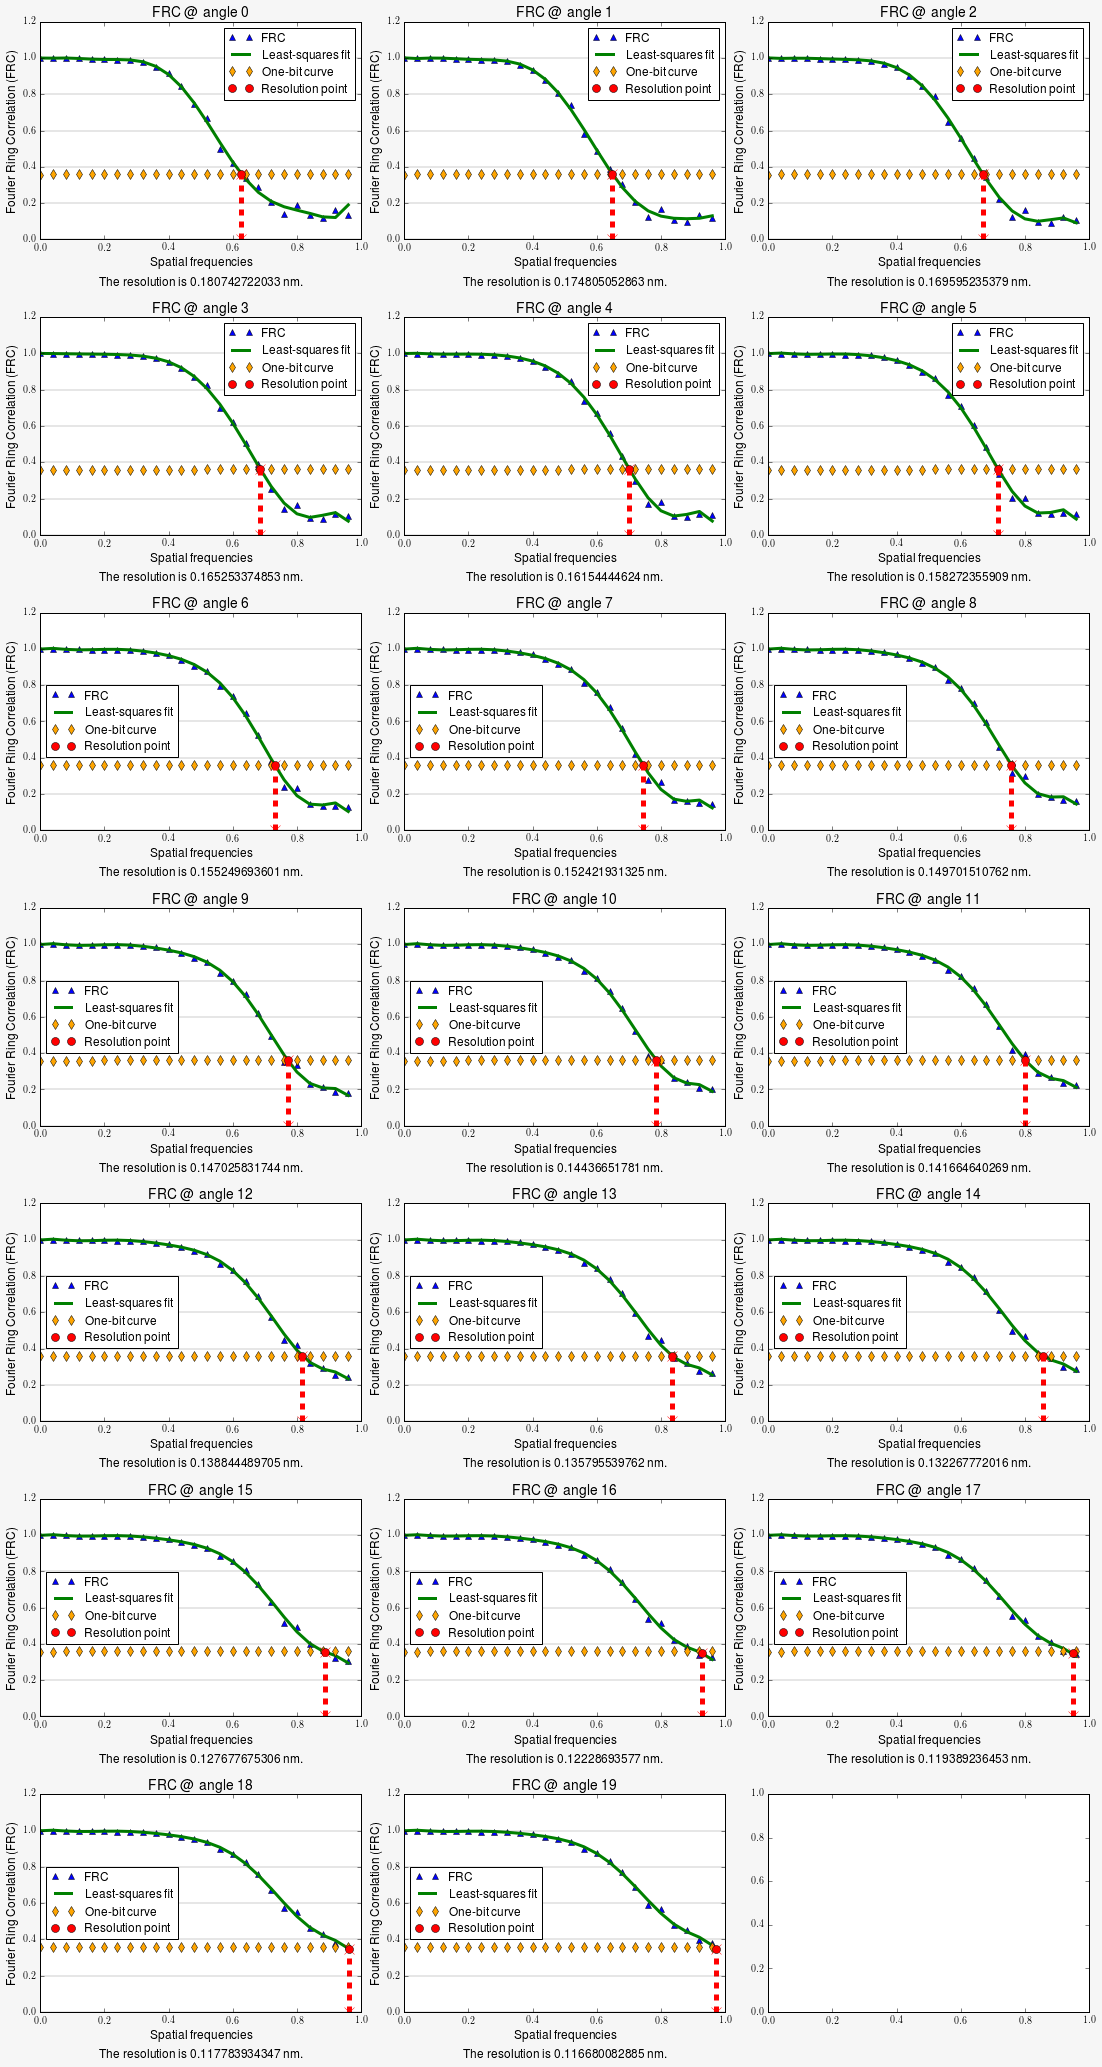

In [19]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

In [20]:
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.appen(dataset[1].resolution["resolution"])
    
pri


deconvolution_parameters = task.get_saved_data()

#curves = dataframe.loc[:, ['solofrc', 'duofrc', 'tau1', 'u_esu']]

#curves['solofrc'] -= curves['solofrc'].min()
#curves['solofrc'] /= curves['solofrc'].max()

#curves['duofrc'] -= curves['duofrc'].min()
#curves['duofrc'] /= curves['duofrc'].max()

#curves['tau1'] -= curves['tau1'].min()
#curves['tau1'] /= curves['tau1'].max()

#curves['u_esu'] -= curves['u_esu'].min()
#curves['u_esu'] /= curves['u_esu'].max() 


#curves.plot()

print dataframe

AttributeError: 'list' object has no attribute 'appen'

In [ ]:
print image1.spacing